In [8]:
fstconf = "_fst_high"
resfile = f'/cbscratch/franco/trans-eqtl/protein_coding_lncRNA_gamma01_knn30_cut5e-8{fstconf}/dhs_enrichments/dhs_enrichment_multi_tissue_pc_lncRNA_gamma01_knn30_cut5e-8_ldpruned.txt'
aresfile = f'/cbscratch/franco/trans-eqtl/protein_coding_lncRNA_gamma0006_knn30_cut5e-8{fstconf}/dhs_enrichments/dhs_enrichment_multi_tissue_pc_lncRNA_gamma0006_knn30_cut5e-8_ldpruned.txt'
tissue_file = '../../plots/tissue_table.txt'
json_file = '../../gtex_v8_metadata.json'

In [29]:
import numpy as np
import collections
import json
import matplotlib.pyplot as plt
import sys
sys.path.append("../../utils")
import utils
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 14, colors = 'banskt', dpi = 90)

###################
use_brain = False
only_brain= False
###################

In [30]:
RESINFO_FIELDS = ['ntrans', 'enrich', 'pvalue']
class ResInfo(collections.namedtuple('_ResInfo', RESINFO_FIELDS)):
    __slots__ = ()

def read_results(filename):
    res = dict()
    with open(filename, 'r') as infile:
        next(infile)
        for line in infile:
            linesplit = line.strip().split()
            tissue = linesplit[0]
            ntrans = int(linesplit[2].strip())
            enrich = float(linesplit[4].strip())
            pvalue = float(linesplit[5].strip())
            res[tissue] = ResInfo(ntrans = ntrans, enrich = enrich, pvalue = pvalue)
    return res

res = read_results(resfile)
ares = read_results(aresfile)

In [31]:
tshorts, tfulls, tstrings = utils.read_tissues_str(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
tissue_nsamples = dict()

for tshort, tfull, tstring in zip(tshorts, tfulls, tstrings):
    if tshort in tshorts:
        tissue_names[tshort] = tstring
        tissue_colors[tshort] = "#" + gtex_meta[tfull]["colorHex"]
        tissue_nsamples[tshort] = gtex_meta[tfull]["rnaSeqSampleCount"]
        
brain_tissues = ['bam', 'ban', 'bca', 'bceh', 'bce', 'bco', 'bfr', 'bhi', 'bhy', 'bnu', 'bpu', 'bsp', 'bsu']
if use_brain and not only_brain:
    brain_tissues = []
#altsb_tissues = ['ag', 'haa', 'liv', 'msg', 'pan', 'pit', 'si', 'spl', 'va', 'wb']
altsb_tissues = ['haa', 'pan', 'spl', 'wb']

In [32]:
cres = dict() # hold combined result
for t in tshorts:
    if t in altsb_tissues and t in ares.keys():
        cres[t] = ares[t]
    elif t in res.keys():
        cres[t] = res[t]

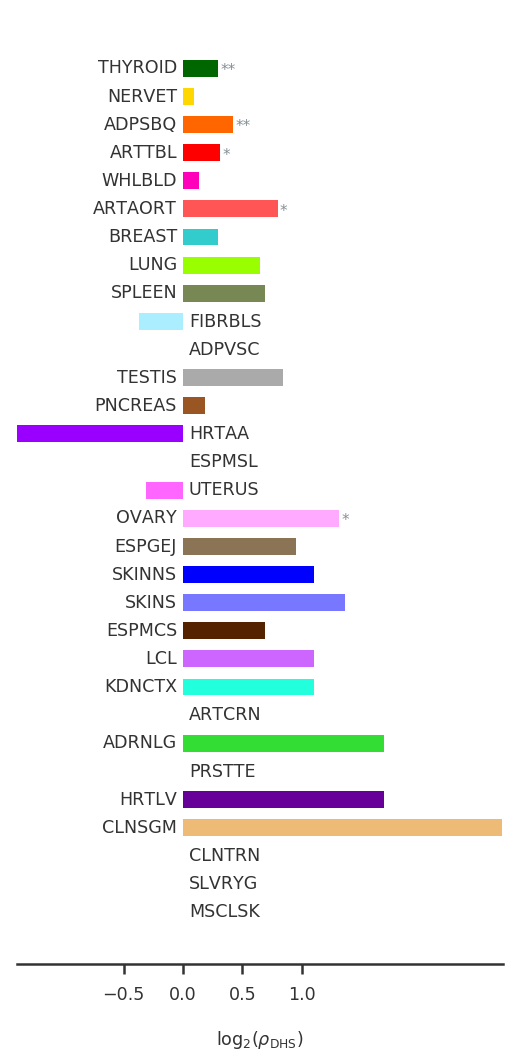

In [33]:
objects = list()
performance = list()
significance = list()
bar_colors = list()
bar_heights = list()

includetissues = [x for x in tshorts if x in cres.keys()
                                  #and tissue_nsamples[x] >= 250
                                  #and cres[x].ntrans > 40
                                  #and cres[x].enrich != 0
                                  and x not in brain_tissues
                 ]
if only_brain:
    includetissues = [x for x in tshorts if x in cres.keys() and x in brain_tissues]
    
sorted_idx = np.argsort(np.array([cres[x].ntrans for x in includetissues]))[::-1]
whichtissues = [includetissues[i] for i in sorted_idx]
whichtissues.reverse()

# don't delete. required for variable bar height
#nmax = max([tissue_nsamples[t] for t in whichtissues])

for tshort in whichtissues:
        nteqtl = cres[tshort].ntrans
        if nteqtl == 0:
            objects.append(tissue_names[tshort])
            performance.append(0)
            significance.append('')
        else:            
            tf_enrichment = cres[tshort].enrich if cres[tshort].enrich != 0 else 1
            tf_enrichment_pval = cres[tshort].pvalue

            objects.append(tissue_names[tshort])
            performance.append(np.log2(tf_enrichment))

            if tf_enrichment_pval <= 0.001:
                significance.append('***')
            elif tf_enrichment_pval <= 0.01:
                significance.append('**')
            elif tf_enrichment_pval <= 0.05:
                significance.append('*')
            else:
                significance.append('')
                    
        #height = 0.05 + 0.75 * tissue_nsamples[tshort] / nmax
        #height = 0.002 * nteqtl
        height = 0.6
        bar_colors.append(tissue_colors[tshort])
        bar_heights.append(height)
        
if only_brain:
    figsize = (6, 5)
else:
    figsize = (6, 12)
fig = plt.figure(figsize = figsize)
ax1 = fig.add_subplot(111)

y_pos = np.arange(len(objects))
bar1 = ax1.barh(y_pos, performance, align='center', color = bar_colors, linewidth = 0, height = bar_heights)

ax1.set_xlabel(r'$\log_2(\rho_{\mathrm{DHS}})$')
xmax = np.around(np.max(performance) + 0.05, decimals = 1)
xmin = np.around(np.min(performance) - 0.05, decimals = 1)
ax1.set_xlim([xmin, xmax])

ax1.tick_params(bottom = True, top = False, left = False, right = False, labelleft = False, labelbottom = True)
for side, border in ax1.spines.items():
    if not side == 'bottom':
        border.set_visible(False)

mcolor = '#848f94'
mfontsize = 14
# Add tissue names the bars
for i, rect in enumerate(bar1):
    width = rect.get_width()
    ypos = rect.get_y() + rect.get_height() / 2.0
    xpos = 0.05
    if performance[i] > 0:
        ax1.text(-xpos, ypos, objects[i], ha='right', va='center', fontsize = mfontsize)
    else:
        ax1.text(xpos, ypos, objects[i], ha='left', va='center', fontsize = mfontsize)
    
# Add p-values beside the bars
for i, rect in enumerate(bar1):
    width = rect.get_width()
    xpos = rect.get_width() + 0.02
    ypos = rect.get_y() + rect.get_height() / 2.0 - 0.08
    ax1.text(xpos, ypos, f'{significance[i]}', ha='left', va='center', color = mcolor, fontsize = 12)


ax1.set_xticks([-0.5, 0, 0.5, 1.0])

plt.tight_layout()
if use_brain:
    if only_brain:
        plt.savefig(f'gtex_{fstconf}_trans_eqtl_dhs_enrichment_only_brain.pdf', bbox_inches='tight')
        plt.savefig(f'gtex_{fstconf}_trans_eqtl_dhs_enrichment_only_brain.png', bbox_inches='tight')
    else:
        plt.savefig(f'gtex_{fstconf}_trans_eqtl_dhs_enrichment_w_brain.pdf', bbox_inches='tight')
        plt.savefig(f'gtex_{fstconf}_trans_eqtl_dhs_enrichment_w_brain.png', bbox_inches='tight')
else:
    plt.savefig(f'gtex_{fstconf}_trans_eqtl_dhs_enrichment.pdf', bbox_inches='tight')
    plt.savefig(f'gtex_{fstconf}_trans_eqtl_dhs_enrichment.png', bbox_inches='tight')
plt.show()

## Compare high vs low Fst enrichments

In [34]:
fstconf = "_fst_high"
resfile = f'/cbscratch/franco/trans-eqtl/protein_coding_lncRNA_gamma01_knn30_cut5e-8{fstconf}/dhs_enrichments/dhs_enrichment_multi_tissue_pc_lncRNA_gamma01_knn30_cut5e-8_ldpruned.txt'
aresfile = f'/cbscratch/franco/trans-eqtl/protein_coding_lncRNA_gamma0006_knn30_cut5e-8{fstconf}/dhs_enrichments/dhs_enrichment_multi_tissue_pc_lncRNA_gamma0006_knn30_cut5e-8_ldpruned.txt'

high_res = read_results(resfile)
ahigh_res = read_results(aresfile)

high_cres = dict() # hold combined result
for t in tshorts:
    if t in altsb_tissues and t in ahigh_res.keys():
        high_cres[t] = ahigh_res[t]
    elif t in high_res.keys():
        high_cres[t] = high_res[t]


fstconf = "_fst015"
resfile = f'/cbscratch/franco/trans-eqtl/protein_coding_lncRNA_gamma01_knn30_cut5e-8{fstconf}/dhs_enrichments/dhs_enrichment_multi_tissue_pc_lncRNA_gamma01_knn30_cut5e-8_ldpruned.txt'
aresfile = f'/cbscratch/franco/trans-eqtl/protein_coding_lncRNA_gamma0006_knn30_cut5e-8{fstconf}/dhs_enrichments/dhs_enrichment_multi_tissue_pc_lncRNA_gamma0006_knn30_cut5e-8_ldpruned.txt'

low_res = read_results(resfile)
alow_res = read_results(aresfile)

low_cres = dict() # hold combined result
for t in tshorts:
    if t in altsb_tissues and t in alow_res.keys():
        low_cres[t] = alow_res[t]
    elif t in low_res.keys():
        low_cres[t] = low_res[t]

In [35]:
includetissues = [x for x in tshorts if x in low_cres.keys() and x in high_cres.keys()
                                  #and tissue_nsamples[x] >= 250
                                  #and cres[x].ntrans > 40
                                  #and cres[x].enrich != 0
                                  and x not in brain_tissues
                 ]

low_enrich = [low_cres[x].enrich for x in includetissues]
high_enrich = [high_cres[x].enrich for x in includetissues]

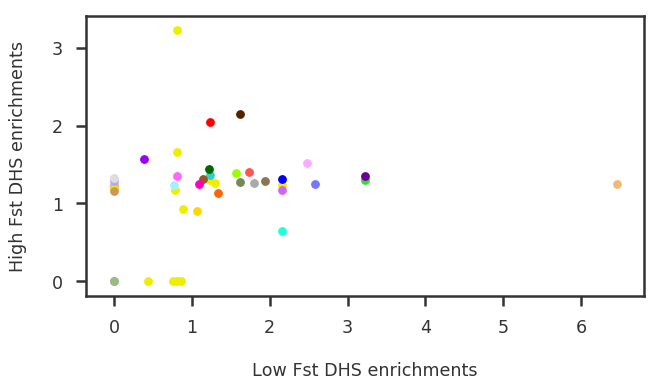

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)
for t in tshorts:
    if t in low_cres and t in high_cres:
        ax.scatter(low_cres[t].enrich, high_cres[t].enrich, color=tissue_colors[t])
#         if low_cres[t].pvalue < 0.05 and high_cres[t].pvalue < 0.05:
#             ax.scatter(low_cres[t].enrich, high_cres[t].enrich, color='red', marker='x')
ax.set_xlabel("Low Fst DHS enrichments")
ax.set_ylabel("High Fst DHS enrichments")
ax.set_aspect("equal")
# ax.set_ylim(0,7)
plt.show()